## **환경 설정**

In [5]:
#빅쿼리 접속
from google.oauth2 import service_account
from google.cloud import bigquery
credential_path = ""
credentials = service_account.Credentials.from_service_account_file(credential_path)
client = bigquery.Client(credentials=credentials, project='road-traffic-safety-388112')

#시각화 라이브러리 호출
import csv
import pandas as pd
import folium
from matplotlib import pyplot as plt
import numpy as np

#한글 설치
import os
if not os.name == 'posix':
    plt.rc("font", family="Malgun Gothic")

import matplotlib.font_manager as fm
font_path = r'C:\WINDOWS\FONTS\MALGUNSL.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)

## **시각화 함수 외**

In [7]:
#그래프 함수
def draw_bar_chart(list_x, list_y, chart_title, color_list = '#003f7d'):
    plt.bar(list_x, list_y, color = color_list)
    plt.title(chart_title)
    plt.xticks(list_x, rotation = 45, ha = 'right')
    plt.show()
    
def draw_line_chart(list_x, list_y, chart_title, label_name = 'None', color_list ='#003f7d' ):
    plt.plot(list_x, list_y, marker='o', markersize=5, label = label_name, color = color_list)
    plt.legend()
    plt.xticks(rotation = 45, ha = 'right')
    plt.title(chart_title)
    plt.show()
    
def draw_pie_chart(list_x, list_y, chart_title, color_list = '#003f7d'):
    plt.pie(list_y, labels=list_x, autopct='%.1f%%', colors = color_list)
    plt.title(chart_title)
    plt.show()
    
#쿼리 실행 함수
def execute_query(query):
    go_query = query

    job = client.query(go_query)
    result = job.result()
    return result

## **EDA_Seoul**

### **피해자**

#### p.8 서울시 시간별 보행자 사망자 수 (2022년)

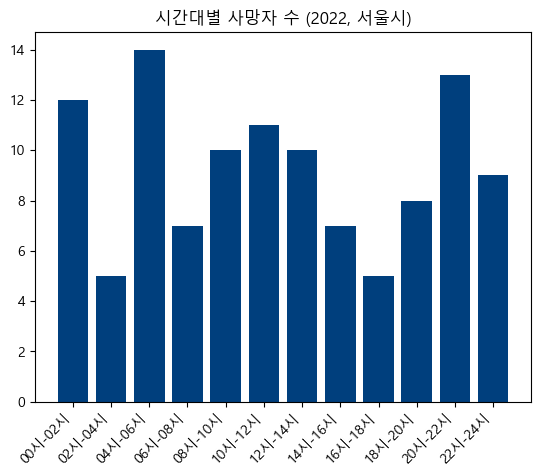

In [9]:
target_year = '2022'

by_year_query = f"""
SELECT
  hours,
  SUM(counts) AS total,
  SUM(death_toll) AS death_toll,
  SUM(serious_injury) AS serious_injury,
  SUM(minor_injury) AS minor_injury,
  SUM(injury_report) AS injury_report
FROM `Traffic_Accidents.Pedestrian_Hours_Seoul`
WHERE years = {target_year}
GROUP BY hours
ORDER BY hours;
"""

hour_list = []
total_list = []
death_list = []
serious_list = []
minor_list = []
report_list = []

for hour, total, death, serious, minor, report in execute_query(by_year_query):
    hour_list.append(hour)
    total_list.append(total)
    death_list.append(death)
    serious_list.append(serious)
    minor_list.append(minor)
    report_list.append(report)

draw_bar_chart(hour_list, death_list, chart_title = f"시간대별 사망자 수 ({target_year}, 서울시)")

#### p.8 서울시 월별 사망 보행자 수 (2022년)

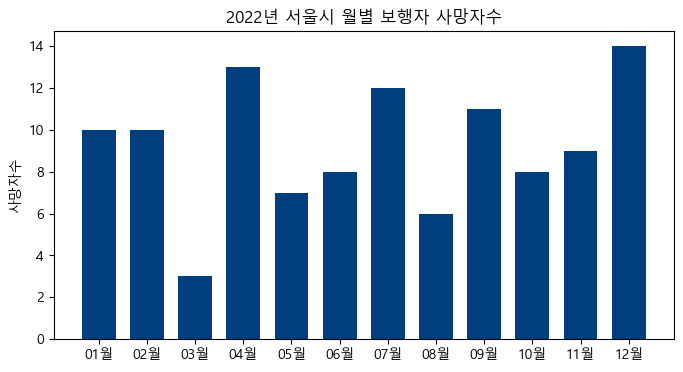

In [18]:
query = f"""
SELECT months,
SUM(death_toll) AS counts
FROM `road-traffic-safety-388112.Traffic_Accidents.seoul_pedestrian_monthly`
WHERE years = 2022
GROUP BY months
ORDER BY months
"""

query_job = client.query(query)
results = query_job.result()

result = []
for row in results:
    result.append(row)

x_month = []
y_count = []

for row in result:
    month, count = row[0], row[1]
    x_month.append(month)
    y_count.append(count)

color = '#003f7d'
plt.figure(figsize=(8, 4))

plt.bar(x_month, y_count,color=color, width=0.7)
plt.xlabel("")
plt.ylabel("사망자수")


plt.title("2022년 서울시 월별 보행자 사망자수")
plt.show()

### **가해자**

#### p. 8 서울시 가해자 연령별 보행자 사망자 수 (2022년)

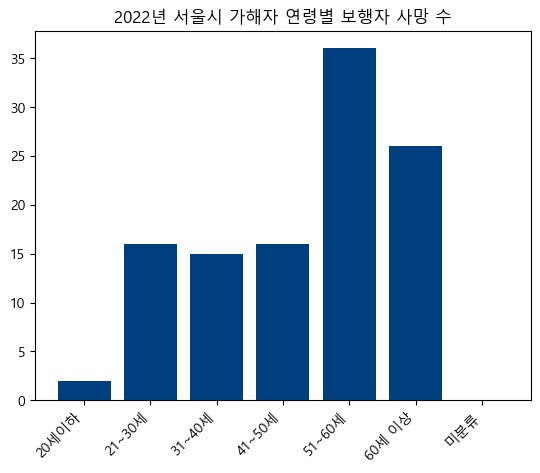

In [8]:
#쿼리 요청 및 결과
seoul_driver_query ="""
SELECT
    age,
    SUM(death_toll)
FROM `road-traffic-safety-388112.Traffic_Accidents.Seoul_Perpetrator_Age`
WHERE year = 2022
GROUP BY age
ORDER BY age
"""

age_list = []
death_list = []

for age, death in execute_query(seoul_driver_query):
    age_list.append(age)
    death_list.append(death)


#60세~65세와 65세~70세 데이터 60대로 통합
death_list[5]=death_list[5]+death_list[6]
age_list[5]='60세 이상'

del death_list[6]
del age_list[6]

draw_bar_chart(age_list, death_list, chart_title="2022년 서울시 가해자 연령별 보행자 사망 수")

#### p.8 가해 운전자 성별 비중 (2022년, 서울시)

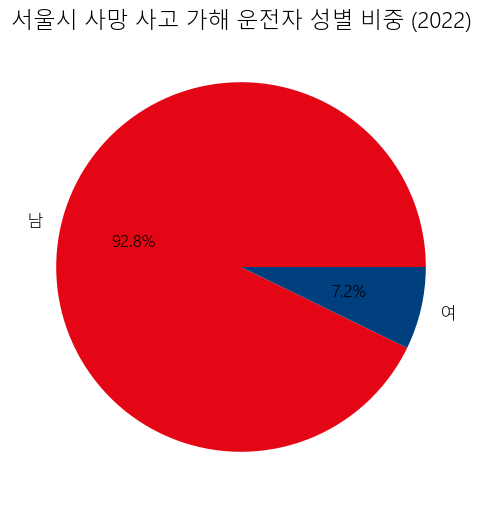

In [16]:
query = """
SELECT year,
    gender,
    death_toll,
    serious_injury,
    minor_injury,
    injury_report

FROM `road-traffic-safety-388112.Traffic_Accidents.Seoul_Perpetrator_Gender`
WHERE gender != '기타불명'
"""
query_job = client.query(query)
results = query_job.result()
colors = ['#e40615', '#003f7d','#f8be31', '#fd7702', '#666a73','lightblue','lightyellow']
# Store the results in lists
gender_list = []
death_toll_list = []
for row in results:
    gender_list.append(row.gender)
    death_toll_list.append(row.death_toll)

# Plotting the pie chart for age
plt.figure(figsize=(8, 6))
plt.pie(death_toll_list, labels=gender_list, autopct='%1.1f%%',textprops={'fontproperties': fontprop}, colors = colors)
plt.title('서울시 사망 사고 가해 운전자 성별 비중 (2022)', fontproperties=fontprop).set_fontsize(16)

plt.show()